# Imports

In [35]:
%load_ext autoreload
%autoreload 2

import os
import math
import time
import csv

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask
from tqdm import tqdm

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from torch.utils.data import DataLoader, Subset

import multiprocessing
import uuid

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset

from memflow.ttH.models.TransferCFM import StandardCFM as TransferCFM
from memflow.ttH.models.Transfusion import StandardCFM as Transfusion
from memflow.ttH.models.ParallelTransfusion import StandardCFM as ParallelTransfusion
from memflow.ttH.models.TransferCFM_original import StandardCFM as OriginalCFM
from transfer_flow.transfer_flow_model import *
from transfer_flow.custom_flows import *

from models.utils import move_batch_to_device
from timings_analysis import plot_inference_time

num_workers = min(16, multiprocessing.cpu_count())  # Use up to 16 CPU cores
print(f'Number of CPU workers for dataloading: {num_workers}')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of CPU workers for dataloading: 16
Running on GPU : True
Accelerator : cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 578531 KiB |   4861 MiB |  15099 GiB |  15098 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 578531 KiB |   4861 MiB |  15099 GiB |  15098 GiB |
|------------------------------------------------

# Data

In [2]:
data_hard = ParquetData(
    files = [
        #'/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        '/home/themrluke/projects/Datasets/MEM/ttH_HToInvisible_M125_hard.parquet',
    ],
    lazy = True,
    # N = int(1e5),
)

print (data_hard)

Data object
Loaded branches:
   ... file: 1903554
   ... sample: 1903554
   ... tree: 1903554
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... W_minus_from_antitop_eta
   ... W_minus_from_antitop_genPartIdxMother
   ... W_minus_from_antitop_idx
   ... W_minus_from_antitop_mass
   ... W_minus_from_antitop_pdgId
   ... W_minus_from_antitop_phi
   ... W_minus_from_antitop_pt
   ... W_minus_from_antitop_status
   ... W_minus_from_antitop_statusFlags
   ... W_plus_from_top_eta
   ... W_plus_from_top_genPartIdxMother
   ... W_plus_from_top_idx
   ... W_plus_from_top_mass
   ... W_plus_from_top_pdgId
   ... W_plus_from_top_phi
   ... W_plus_from_top_pt
   ... W_plus_from_top_status
   ... W_plus_from_top_statusFlags
   ... Z_from_higgs_eta
   ... Z_from_higgs_genPartIdxMother
   ... Z_from_higgs_idx
   ... Z_from_higgs_mass
   ... Z_from_higgs_pdgId
   ... Z_from_higgs_phi

# Hard dataset

In [3]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)

print(hard_dataset)

Loading objects from /home/themrluke/projects/MEM/memflow/ttH/ttH_hard
Saving preprocessing to /home/themrluke/projects/MEM/memflow/ttH/ttH_hard
Will overwrite what is in output directory /home/themrluke/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Preprocessing saved in /home/themrluke/projects/MEM/memflow/ttH/ttH_hard/preprocessing
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
Ws         : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : False
neutrinos  : data ([756642, 4, 5]), mask ([756642, 4])
             Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%]
             Mask attn     : [True, True, True, T

# Reco dataset

In [4]:
data_reco = ParquetData(
    files = [
        #'/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
        '/home/themrluke/projects/Datasets/MEM/ttH_HToInvisible_M125_reco.parquet',
    ],
    lazy = True,
    #N = data_hard.N,
)

print(data_reco)

Data object
Loaded branches:
   ... file: 231528
   ... sample: 231528
   ... tree: 231528
Branch in files not loaded:
   ... Generator_scalePDF
   ... Generator_weight
   ... Generator_x1
   ... Generator_x2
   ... Generator_xpdf1
   ... Generator_xpdf2
   ... InputMet_phi
   ... InputMet_pt
   ... cleanedJet_btagDeepFlavB
   ... cleanedJet_eta
   ... cleanedJet_mass
   ... cleanedJet_phi
   ... cleanedJet_pt
   ... event
   ... ncleanedBJet
   ... ncleanedJet
   ... region
   ... weight_nominal
   ... xs_weight


Have a look at athe minimum values for Jet and MET pT in the raw dataset. This can give an indication as to what the cutoff in the SR is and hence what to set the `'pt':lowercutshift()` to in the pre-processing

In [5]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Loading objects from /home/themrluke/projects/MEM/memflow/ttH/ttH_reco
Saving preprocessing to /home/themrluke/projects/MEM/memflow/ttH/ttH_reco
Will overwrite what is in output directory /home/themrluke/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Preprocessing saved in /home/themrluke/projects/MEM/memflow/ttH/ttH_reco/preprocessing
Reco dataset with 114647 events
Containing the following tensors
met   : data ([114647, 1, 4]), mask ([114647, 1])
        Mask exist    : [100.00%]
        Mask attn     : [True]
        Weights       : 114647.00
        Features      : ['pt', 'eta', 'phi', 'mass']
        Selected for batches : True
jets  : data ([114647, 6, 5]), mask ([114647, 6])
        Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 62.85%]
        Mask attn     : [True, True, True, True, True, True]
        Weights       : 114647.00, 114647.00, 114647.00, 114647.00, 114647.00, 114647.00
        Features      : ['pt', 'eta', 'phi', 'mass', 'btag']
        Selected fo

# Combined dataset

In [6]:
combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print(combined_dataset)

Intersection branches : `event` for hard dataset and `event` for reco dataset
Looking into file metadata
Will pair these files together :
   - /home/themrluke/projects/Datasets/MEM/ttH_HToInvisible_M125_hard.parquet <-> /home/themrluke/projects/Datasets/MEM/ttH_HToInvisible_M125_reco.parquet
For entry 0 : from 756642 events, 91819 selected
For entry 1 : from 114647 events, 91819 selected
Combined dataset (extracting 91819 events of the following) :
Parton dataset with 756642 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6]
 Final states masses   : [125.2, 172.57, 172.57]
Containing the following tensors
Ws         : data ([756642, 2, 5]), mask ([756642, 2])
             Mask exist    : [100.00%, 100.00%]
             Mask attn     : [True, True]
             Weights       : 756642.00, 756642.00
             Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
             Selected for batches : False
neutrinos  : data ([756642, 4, 5]), mask ([756642, 4])
 

In [7]:
TransferCFM_model = TransferCFM.load_from_checkpoint(checkpoint_path="trained_model_checkpoints/TransferCFM_checkpoints/model_epoch_500.ckpt")
TransferCFM_model.to(accelerator)
TransferCFM_model.eval()

No hard attention mask provided; will use existence mask only.


/home/themrluke/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.activation_relu_or_gelu was not True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_fea

In [8]:
ParallelTransfusion_model = ParallelTransfusion.load_from_checkpoint(checkpoint_path="trained_model_checkpoints/parallel_transfusion_checkpoints/model_epoch_500.ckpt")
ParallelTransfusion_model.to(accelerator)
ParallelTransfusion_model.eval()

No hard attention mask provided; will use existence mask only.
Transformer args: will override `d_model` to 64
('pt', 'eta', 'phi', 'mass')
('pt', 'phi')


StandardCFM(
  (hard_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=6, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (1): Sequential(
      (0): CircularEmbedding(
        (linear): Linear(in_features=5, out_features=32, bias=True)
        (act): GELU(approximate='none')
      )
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj)

In [9]:
transfermer_model = TransferFlow.load_from_checkpoint(
    checkpoint_path="trained_model_checkpoints/TransferFlow_checkpoints/model_epoch_500.ckpt",
    encoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.hard_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    decoder_embeddings=MultiEmbeddings(
        features_per_type=combined_dataset.reco_dataset.input_features,
        embed_dims=[32, 64],
        hidden_activation=nn.GELU,
    ),
    transformer=Transformer(
        d_model=64,
        encoder_layers=6,
        decoder_layers=8,
        nhead=8,
        dim_feedforward=256,
        activation=nn.GELU,
        encoder_mask_attn=None,
        decoder_mask_attn=combined_dataset.reco_dataset.attention_mask,
        use_null_token=True,
        dropout=0.0,
    ),
    flow=KinematicFlow(
        d_model=64,
        flow_mode='global',
        flow_features=[
            ['pt', 'eta', 'phi', 'mass'],  # jets
            ['pt', 'phi'],  # met
        ],
        flow_classes={
            'pt': zuko.flows.NSF,
            'eta': UniformNSF,
            'phi': UniformNCSF,
            'mass': zuko.flows.NSF,
        },
        flow_common_args={
            'bins': 16,
            'transforms': 5,
            'randperm': True,
            'passes': None,
            'hidden_features': [256] * 3,
        },
        flow_specific_args={
            'eta': {'bound': 1.0},
            'phi': {'bound': math.pi},
        },
    ),
)
transfermer_model.to(accelerator)
transfermer_model.eval()

/home/themrluke/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder_embeddings' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_embeddings'])`.
/home/themrluke/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'decoder_embeddings' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder_embeddings'])`.
/home/themrluke/miniconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'transformer' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transformer'])`.
/home/themrluke/miniconda3/envs/mem-flow/lib/python3.10/site-pa

TransferFlow(
  (encoder_embeddings): MultiEmbeddings(
    (embeddings): ModuleList(
      (0-2): 3 x MLP(
        (layers): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
    )
  )
  (decoder_embeddings): MultiEmbeddings(
    (embeddings): ModuleList(
      (0): MLP(
        (layers): Sequential(
          (0): Linear(in_features=5, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
      (1): MLP(
        (layers): Sequential(
          (0): Linear(in_features=4, out_features=32, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=32, out_features=64, bias=True)
        )
      )
    )
  )
  (transformer): Transformer(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layer

### Transfermer timings loop

In [26]:
# Define CSV file path
csv_file_path = "timings_data/transfermer_timings.csv"
print(len(combined_dataset))
# Check if the file exists
if os.path.exists(csv_file_path):
    df_existing = pd.read_csv(csv_file_path)
    print(f"Loaded existing data from {csv_file_path}")
else:
    torch.cuda.empty_cache()
    os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)
    df_existing = pd.DataFrame(columns=["Batch Size", "Repeat Number", "Time Taken (seconds)"])
    print(f"File {csv_file_path} does not exist. A new file will be created.")

    # Define batch sizes and number of repetitions per batch size
    batch_sizes = [2,100,500,1000,5000,10000,20000,40000,50000, 60000]
    num_repeats = 1  # Number of times to repeat each batch size measurement

    # Open CSV file for writing
    with open(csv_file_path, mode="w", newline="") as file:
        writer = csv.writer(file)

        # Write header
        writer.writerow(["Batch Size", "Repeat Number", "Time Taken (seconds)"])

        # Iterate over different batch sizes
        for batch_size in batch_sizes:
            for repeat in range(1, num_repeats + 1):
                torch.cuda.empty_cache()
                # Create DataLoader with current batch size
                full_loader = DataLoader(
                    combined_dataset,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=num_workers,
                    pin_memory=True,
                )

                batch = next(iter(full_loader))  # Take just 1 batch
                batch = transfermer_model.transfer_batch_to_device(batch, transfermer_model.device, 0)  # Move to device

                torch.cuda.synchronize()  # Ensure accurate timing if using CUDA
                start_time = time.time()

                with torch.no_grad():
                    # Run inference
                    transfermer_model.sample(
                        batch['hard']['data'],
                        batch['hard']['mask'],
                        batch['reco']['data'],
                        batch['reco']['mask'],
                        N=1  # number of samples per event
                    )
                del batch
                torch.cuda.synchronize()  # Ensure all operations finish
                end_time = time.time()

                elapsed_time = end_time - start_time

                # Write row to CSV
                writer.writerow([batch_size, repeat, elapsed_time])

    print(f"Inference timings saved to {csv_file_path}")


91819
File timings_data/transfermer_timings.csv does not exist. A new file will be created.
Inference timings saved to timings_data/transfermer_timings.csv


findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not 

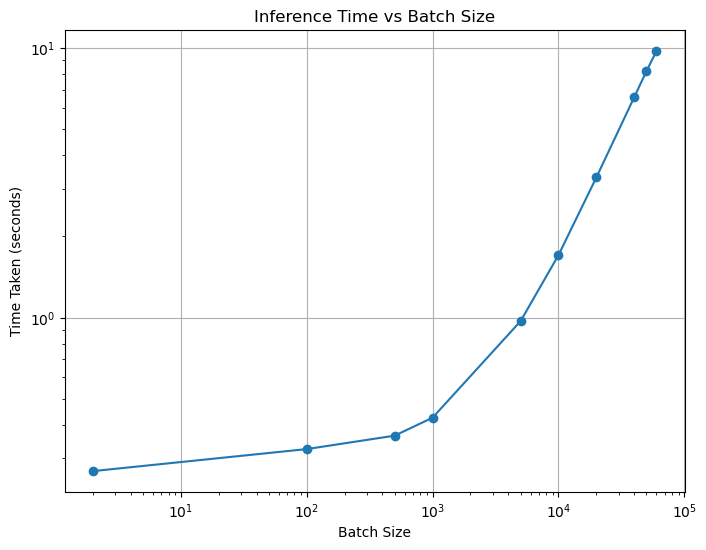

In [36]:

# Call function with your CSV file path
plot_inference_time("timings_data/transfermer_timings.csv")

### Parallel Transfusion Timings

In [31]:
# Define CSV file path
csv_file_path = "timings_data/PT_timings.csv"
print(len(combined_dataset))
# Check if the file exists
if os.path.exists(csv_file_path):
    df_existing = pd.read_csv(csv_file_path)
    print(f"Loaded existing data from {csv_file_path}")
else:
    torch.cuda.empty_cache()
    os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)
    df_existing = pd.DataFrame(columns=["Batch Size", "Repeat Number", "Time Taken (seconds)"])
    print(f"File {csv_file_path} does not exist. A new file will be created.")

    # Define batch sizes and number of repetitions per batch size
    batch_sizes = [2,100,500,1000,5000,20000, 60000]
    num_repeats = 1  # Number of times to repeat each batch size measurement

    # Open CSV file for writing
    with open(csv_file_path, mode="w", newline="") as file:
        writer = csv.writer(file)

        # Write header
        writer.writerow(["Batch Size", "Repeat Number", "Time Taken (seconds)"])

        # Iterate over different batch sizes
        for batch_size in batch_sizes:
            for repeat in range(1, num_repeats + 1):
                torch.cuda.empty_cache()
                # Create DataLoader with current batch size
                full_loader = DataLoader(
                    combined_dataset,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=num_workers,
                    pin_memory=True,
                )

                batch = next(iter(full_loader))  # Take just 1 batch
                batch = ParallelTransfusion_model.transfer_batch_to_device(batch, ParallelTransfusion_model.device, 0)  # Move to device

                torch.cuda.synchronize()  # Ensure accurate timing if using CUDA
                start_time = time.time()

                with torch.no_grad():
                    # Run inference
                    ParallelTransfusion_model.sample(
                        batch['hard']['data'],
                        batch['hard']['mask'],
                        batch['reco']['data'],
                        batch['reco']['mask'],
                        N_sample=1,  # number of samples per event
                        steps=20
                    )
                del batch
                torch.cuda.synchronize()  # Ensure all operations finish
                end_time = time.time()

                elapsed_time = end_time - start_time

                # Write row to CSV
                writer.writerow([batch_size, repeat, elapsed_time])

    print(f"Inference timings saved to {csv_file_path}")


91819
File timings_data/PT_timings.csv does not exist. A new file will be created.
Inference timings saved to timings_data/PT_timings.csv


findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not 

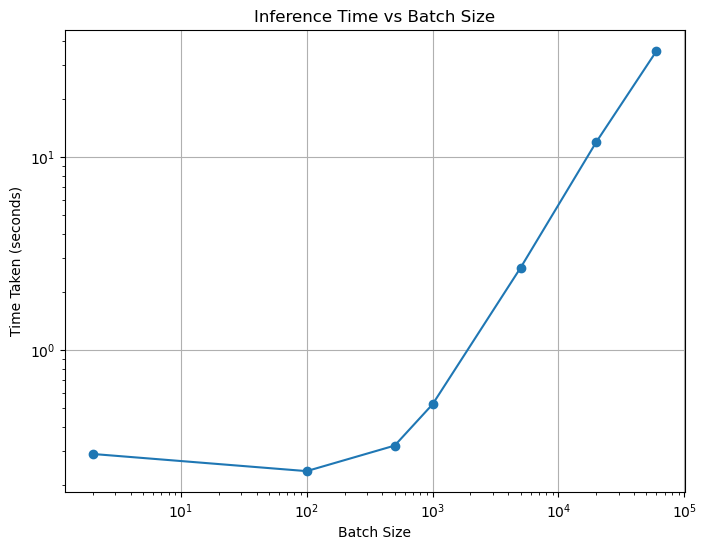

In [37]:
plot_inference_time("timings_data/PT_timings.csv")

In [33]:
# Define CSV file path
csv_file_path = "timings_data/transferCFM_timings.csv"
print(len(combined_dataset))
# Check if the file exists
if os.path.exists(csv_file_path):
    df_existing = pd.read_csv(csv_file_path)
    print(f"Loaded existing data from {csv_file_path}")
else:
    torch.cuda.empty_cache()
    os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)
    df_existing = pd.DataFrame(columns=["Batch Size", "Repeat Number", "Time Taken (seconds)"])
    print(f"File {csv_file_path} does not exist. A new file will be created.")

    # Define batch sizes and number of repetitions per batch size
    batch_sizes = [2,100,500,1000,5000,20000, 60000]
    num_repeats = 1  # Number of times to repeat each batch size measurement

    # Open CSV file for writing
    with open(csv_file_path, mode="w", newline="") as file:
        writer = csv.writer(file)

        # Write header
        writer.writerow(["Batch Size", "Repeat Number", "Time Taken (seconds)"])

        # Iterate over different batch sizes
        for batch_size in batch_sizes:
            for repeat in range(1, num_repeats + 1):
                torch.cuda.empty_cache()
                # Create DataLoader with current batch size
                full_loader = DataLoader(
                    combined_dataset,
                    batch_size=batch_size,
                    shuffle=False,
                    num_workers=num_workers,
                    pin_memory=True,
                )

                batch = next(iter(full_loader))  # Take just 1 batch
                batch = TransferCFM_model.transfer_batch_to_device(batch, TransferCFM_model.device, 0)  # Move to device

                torch.cuda.synchronize()  # Ensure accurate timing if using CUDA
                start_time = time.time()

                with torch.no_grad():
                    # Run inference
                    TransferCFM_model.sample(
                        batch['hard']['data'],
                        batch['hard']['mask'],
                        batch['reco']['data'],
                        batch['reco']['mask'],
                        N_sample=1,  # number of samples per event
                        steps=20
                    )
                del batch
                torch.cuda.synchronize()  # Ensure all operations finish
                end_time = time.time()

                elapsed_time = end_time - start_time

                # Write row to CSV
                writer.writerow([batch_size, repeat, elapsed_time])

    print(f"Inference timings saved to {csv_file_path}")


91819
File timings_data/transferCFM_timings.csv does not exist. A new file will be created.
Inference timings saved to timings_data/transferCFM_timings.csv


findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not found because none of the following families were found: Nimbus Roman
findfont: Generic family 'serif' not 

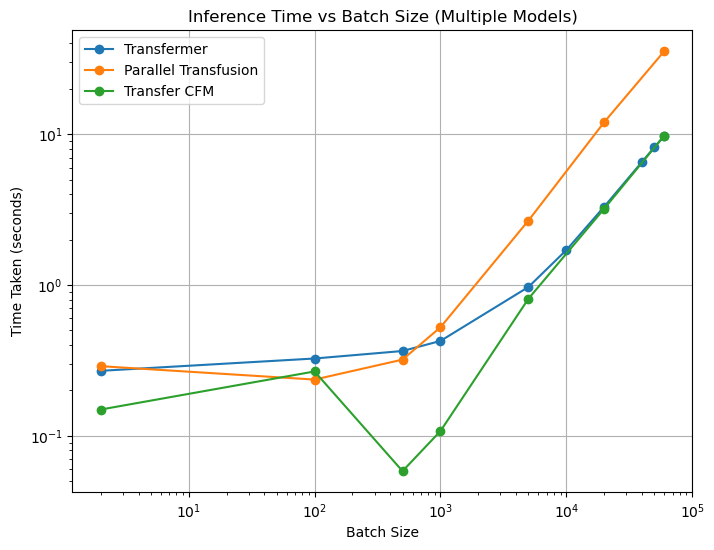

In [39]:
# Define CSV file paths and labels for models
csv_files = [
    "timings_data/transfermer_timings.csv",
    "timings_data/PT_timings.csv",
    "timings_data/transferCFM_timings.csv"
]
labels = ["Transfermer", "Parallel Transfusion", "Transfer CFM"]

# Call function
plot_inference_time(csv_files, labels)
